In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
import scipy.optimize as optimization
from scipy.stats import pearsonr 

In [6]:
#define function used to fit line to data
def slopeintfunc(x,s1,incpt):
    return s1*x+incpt

> ## Loading in Data

In [90]:
def data():
    full = pd.read_csv("SARP WAS 2009-2019.csv", usecols = range(124), nrows = 3136)
    Et = []
    Pe = []
    Bu = []
    Pr = []
    
    #Nitrate / Alkane ratios included for air mass aging purposes
    
    Et = full['EtONO2 (C/D)']/full['Ethane (E)']
    Pe = full['2-PeONO2 (D)']/full['n-Pentane (E)']
    Bu = full['2-BuONO2 (D)']/full['n-Butane (E)']
    Pr = full['n-PrONO2 (C)']/full['Propane (E/B)']
    full['Et ratio'] = Et
    full['Pe ratio'] = Pe
    full['Bu ratio'] = Bu
    full['Pr ratio'] = Pr
    return full

In [3]:
full = data()

In [4]:
for i in full.keys():
    print(i)

Snake#
Can#
Flight
Jday
date
OpenTime
CloseTime
Julian Open Time
Julian Closing Time
Jopen time Progressive
J close time Progressive
Latitude
Longitude
AltP_feet
AltP_meters
Radaralt_ft
Radaralt_m
SARP Year
Weather
Comments
H2 (ppbv)mult by 1.6
CH4 (ppmv)
CO (ppbv)
CO2_ppm
OCS (MS)
DMS (MS)
CFC-12 (C/D)
CFC-11 (C/D)
CFC-113 (D)
CFC-114 (C/MS)
H-1211 (C/D)
H-1301 (C)
H-2402 (D)
HFC-152a (MS)
HFC-134a (MS)
HCFC-22 (MS)
HCFC-142b
HCFC-141b (MS)
HFC-227ea (MS)
HCFC-124 (MS)
HFC-365mfc (MS)
CHCl3 (C/D)
CH3CCl3 (C/MS)
CCl4 (C/MS)
CH2Cl2 (C/D/MS)
C2HCl3 (D/MS)
C2Cl4 (C/MS)
CH3Cl (MS)
CH3Br (C/MS)
CH3I (C/D)
CH2Br2 (D)
CHBrCl2 (D)
CHBr2Cl (D)
CHBr3 (C/MS)
1,2-DCE (MS)
MeONO2 (C/D)
EtONO2 (C/D)
i-PrONO2 (D)
n-PrONO2 (C)
2-BuONO2 (D)
3-PeONO2 (D)
2-PeONO2 (D)
3-Methyl-2-BuONO2 (D)
Ethane (E)
Ethene (E)
Ethyne (E)
Propane (E/B)
Propene (E)
i-Butane (E)
n-Butane (E)
i-Butene (E)
1-Butene (E)
trans-2-Butene (MS)
cis-2-Butene (MS)
i-Pentane (E)
n-Pentane (E)
1-Pentene
Isoprene (E/B)
1,3-Butadiene (B

> ## Constraining Data

In [12]:
def by_year(dataframe, year):
    df = dataframe['SARP Year'].astype(int) == year
    data = dataframe[df]
    return data

In [13]:
def by_alt(dataframe, min_alt, max_alt = 50000):
    altRange = dataframe[(dataframe['AltP_feet'] > min_alt) & (dataframe['AltP_feet'] < max_alt)]
    return altRange

In [14]:
def by_latlong(dataframe, minlat, maxlat, minlong, maxlong):
    data = dataframe[(dataframe['Latitude'] > minlat) & (dataframe['Latitude'] < maxlat) & (dataframe['Longitude'] > minlong) & (dataframe['Longitude'] < maxlong)]
    return data

In [15]:
def by_flight(dataframe, number):
    df = dataframe['Flight'].astype(str) == number
    data = dataframe[df]
    return data

In [16]:
def by_compound(dataframe, compound, minval, maxval):
    data = dataframe[(dataframe[compound] > minval) & (dataframe[compound] < maxval)]
    return data

> ## Analyzing and Visualizing Data

In [18]:
def median_getter(df, var, min_alt, max_alt):
    '''
    Using WAS data throughout the years, this method calculates the median value
    of var in dataset df, within the altitude range (min_alt, max_alt)
    '''
    altRange = df[(df['AltP_feet'] > min_alt) & (df['AltP_feet'] < max_alt)]
    med = np.nanmedian(altRange[var])
    return round(med, 1)

In [20]:
def scatter1(data, x, y, s='', c='', bestfit = "no"):
    '''
    This function will create a scatterplot of two variables, x and y. 
    df = dataset
    To make a colormap of another variable, set c = columnname.
    To make point size correspond to another variable, set s = columnname. 
    To add a line of best fit for the xaxis and yaxis variables, set bestfit = "yes".
    '''
    xaxis = data[x]
    yaxis = data[y]
    
    if c != '' and s != '':
        coloraxis = data[c]
        sizeaxis = (data[s]/(data[s].max()))*400
        plt.title(str(y)+" vs "+str(x)+" with color representing "+str(c)+ " and size representing "+str(s))
    elif c != '':
        coloraxis = data[c]
        sizeaxis = None
        plt.title(str(y)+" vs "+str(x)+" with color representing "+str(c))
    elif s != '':
        coloraxis2011 = None
        sizeaxis = (data[s]/(data[s].max()))*400
        plt.title(str(y)+" vs "+str(x)+" with size representing "+str(s))
    else:
        sizeaxis = None
        plt.title(str(y)+" vs "+str(x))
    
    plt.scatter(xaxis, yaxis, s = sizeaxis, c = coloraxis, cmap = 'plasma')
    if c != '':
        plt.colorbar(orientation="vertical" , label = str(c))
    plt.xlabel(str(x))
    plt.ylabel(str(y))
    
    if bestfit == "yes":
        cleany = yaxis[(np.isnan(data[y])==False) & (np.isnan(data[x])==False)]
        cleanx = xaxis[(np.isnan(data[y])==False) & (np.isnan(data[x])==False)]
        best = optimization.curve_fit(slopeintfunc, cleanx, cleany)
        print("slope, int =",best[0])
        print("(R (correleation coefficient), p-value) =",pearsonr(cleanx, cleany))
        if c == '':
            plt.plot(cleanx, slopeintfunc(cleanx, best[0][0], best[0][1]), color = "salmon")
        else:
            plt.plot(cleanx, slopeintfunc(cleanx, best[0][0], best[0][1]), color = "cornflowerblue")

In [56]:
#scatter1 example

slope, int = [ 363.32641904 -578.83822339]
(R (correleation coefficient), p-value) = (0.44614839968953546, 1.920413347651765e-113)


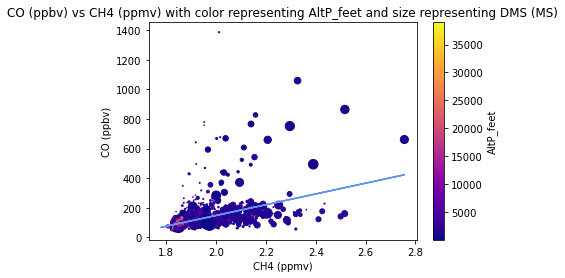

In [64]:
scatter1(full, 'CH4 (ppmv)', 'CO (ppbv)', s='DMS (MS)', c='AltP_feet', bestfit='yes')

In [53]:
def scatter2(df1, label1, df2, label2, x, y, s='', c='', avg=None):
    '''
    This function will create a scatterplot of two variables, x and y
    Comparing two separate populations, df1 and df2 (label1 and label2 are their descriptors, respectively)
    To make a colormap of another variable, set c = columnname.
    To make point size correspond to another variable, set s = columnname. 
    To add a line of best fit for the xaxis and yaxis variables, set bestfit = "yes".
    To plot a dotted blue horizontal line for a median value, use avg (see median_getter above)
    '''
    
    #1st dataset
    x1 = df1[x]
    y1 = df1[y]
    if c != '' and s != '':
        coloraxis1 = df1[c]
        sizeaxis1 = (df1[s]/(df1[s].max()))*400
    elif c != '':
        sizeaxis1 = None
        coloraxis1 = df1[c]
        plt.title(str(y)+" vs "+str(x)+" with color representing "+str(c))
    elif s != '':
        coloraxis1 = None
        sizeaxis1 = (df1[s]/(df1[s].max()))*400
        plt.title(str(y)+" vs "+str(x)+" with size representing "+str(s))
    else:
        coloraxis1 = None
        sizeaxis1 = None
        plt.title(str(y)+" vs "+str(x))

    plt.scatter(x1, y1, s = sizeaxis1, c = coloraxis1, marker = 'o', cmap = 'plasma', label = label1)

    #2nd dataset
    x2 = df2[x]
    y2 = df2[y]
    if c != '' and s != '':
        coloraxis2 = df2[c]
        sizeaxis2 = (df2[s]/(df2[s].max()))*400
    elif c != '':
        sizeaxis2 = None
        coloraxis2 = df2[c]
        plt.title(str(y)+" vs "+str(x)+" with color representing "+str(c))
    elif s != '':
        coloraxis2 = None
        sizeaxis2 = (df2[s]/(df2[s].max()))*400
        plt.title(str(y)+" vs "+str(x)+" with size representing "+str(s))
    else:
        coloraxis2 = None
        sizeaxis2 = None
        plt.title(str(y)+" vs "+str(x))

    plt.scatter(x2, y2, s = sizeaxis2, c = coloraxis2, marker = '*', cmap = 'plasma', label = label2)

    if c != '':
        plt.colorbar(label = str(c))
    #plt.title(str(y)+" vs "+str(x)+" with color representing "+str(c)+ " and size representing "+str(s))
    plt.xlabel(str(x))
    plt.ylabel(str(y))
    
    if avg != None:
        plt.hlines(avg, 11750, 13785, colors=['skyblue'], linestyles='dashed', label = 'Median ' + str(y) + ' Value = '+str(avg))
    plt.legend()
    plt.show()

In [58]:
flight_1_2015 = by_flight(by_year(full, 2015), '1')
flight_4_2011 = by_flight(by_year(full, 2011), '4')

In [59]:
#scatter2 example

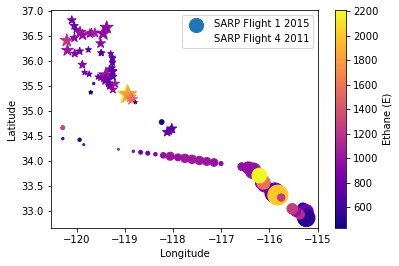

In [69]:
scatter2(flight_1_2015, 'SARP Flight 1 2015', flight_4_2011, 'SARP Flight 4 2011', 'Longitude', 'Latitude', s='Toluene (B)', c='Ethane (E)')

> #### Concentration by Sample Time

In [74]:
def comparison(data, keys, title, vline=0, save=''):
    '''
    This function will create a subplot for all variables vs. Julian Open Time
    of each sample.
    
    args:
    data = flight dataset
    keys = variables/columns of 
    title = the title of your graph
    
    kwargs:
    vline = a Julian Open Time location where you want to plot a vertical line 
    on every subplot
    save = filename if you would like to save total image
    
    ****figsize is meant to match graphing every column, must modify for less than that
    I am not sure why the title is so high above the graph
    '''
    #for some reason CH3I column is initially type string
    data['CH3I (C/D)'] = (data['CH3I (C/D)']).astype(float)
    
    fig, axs = plt.subplots((len(keys)), 1, figsize=(12, 240), sharex = 'col')
    plt.suptitle(title, fontsize = 'xx-large')
    for i,k in enumerate(keys):
        if k=='Comments':
            pass
        else:
            axis = axs[i]
            axis.scatter(data['Julian Open Time'], data[k])
            if vline != 0:
                axis.axvline(x=vline, color = 'salmon')
            axis.set(title=k, ylabel = k)
    axis.set(xlabel = 'Julian Open Time')
    axis.xaxis.set_major_locator(plt.MaxNLocator(20))
    if save != '':
        fig.savefig(save)
    fig.subplots_adjust(top=0.88, wspace=None, hspace=None)


In [75]:
#comparison example

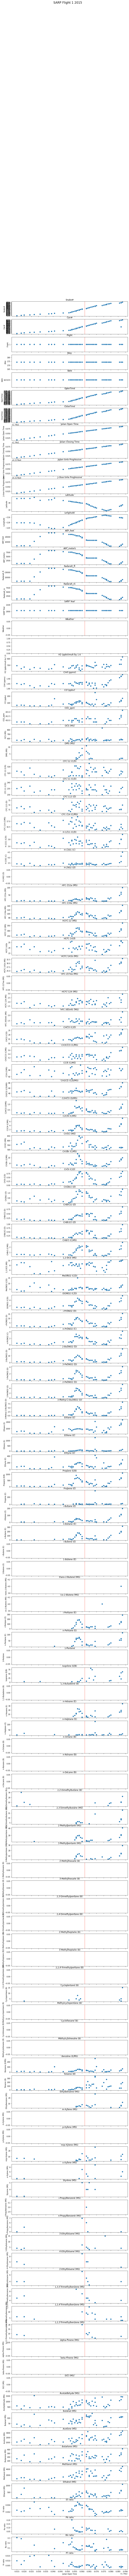

In [73]:
comparison(flight_1_2015, full.keys(), 'SARP Flight 1 2015', vline=174.062)

> #### Yearly Trends

In [86]:
def yearly_trends(df, compound, min_alt=0, max_alt = 50000, minlat=30, maxlat=40, minlong=-125, maxlong=-110, min_year = 2009, max_year = 2019, omissions=[], bestfit = 'no'):
    '''
    yearly_trends uses a dataset to plot the yearly median values of a certain compound
    in a constrained time, area, or altitude
    
    args:
    df = total dataset
    compound = variable of interest
    
    kwargs:
    min_alt
    max_alt
    minlat
    maxlat
    minlong
    maxlong
    min_year
    max_year
    omissions = type list
    bestfit = 'yes' or 'no'
    '''
    years = []
    
    backgrounds = []
    
    altRange = df[(df['AltP_feet'] > min_alt) & (df['AltP_feet'] < max_alt)]
    
    for year in range(min_year, max_year+1):
        if year in omissions:
            pass
        else:
            years.append(year)
            data = by_latlong((by_alt(by_year(df, year), min_alt, max_alt)),minlat, maxlat, minlong, maxlong)
            med = np.nanmedian(data[compound])
            backgrounds.append(med)
    plt.scatter(years, backgrounds)
    plt.title('Median Concentrations of '+compound+' in the Altitude Range \n ('+str(min_alt)+'ft,'+str(max_alt)+'ft) during the years '+str(min_year)+'-'+str(max_year))
    plt.xlabel('Years')
    plt.ylabel(compound)
    plt.xlim(min_year-1, max_year+1) 
    if bestfit == "yes":
        backgrounds = np.array(backgrounds)
        years = np.array(years)
        cleany = backgrounds[(np.isnan(backgrounds)==False) & (np.isnan(years)==False)]
        cleanx = years[(np.isnan(backgrounds)==False) & (np.isnan(years)==False)]
        
        best = optimization.curve_fit(slopeintfunc, cleanx, cleany)
        print("slope, int =",best[0])
        print("(R (correleation coefficient), p-value) =",pearsonr(cleanx, cleany))
        plt.plot(cleanx, slopeintfunc(cleanx, best[0][0], best[0][1]), color = "salmon")
    return (backgrounds, years)

In [87]:
#yearly_trends example

slope, int = [-2.76441176e+01  5.63242294e+04]
(R (correleation coefficient), p-value) = (-0.7959900369420667, 0.010277401978078714)


(array([772. , 688.5, 645. , 703.5, 641.5, 776. , 565.5, 530.5, 463. ]),
 array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019]))

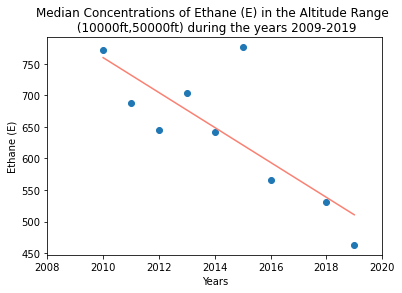

In [88]:
yearly_trends(full, 'Ethane (E)', min_alt=10000, max_alt=50000, omissions=[2009, 2017], bestfit='yes')

> #### Basemap Colormaps

In [131]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ['PROJ_LIB'] = proj_lib

#before this in terminal ---> conda install basemap
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

> #### 3D rotating map gifs

In [113]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

#must download below packages from online before using them: celluloid and ffmpeg
from celluloid import Camera
ffmpeg = plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [114]:
def three_d_cmap(flight, color, filename, title='SARP 3D Map'):
    fig = plt.figure()
    ax = Axes3D(fig)

    def init():
        p = ax.scatter(flight['Longitude'], flight['Latitude'], flight['AltP_feet'], c=flight[color], marker='o', cmap='magma', alpha=0.5)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Altitude')
        ax.set_title(title)
        fig.colorbar(p, label = color)
        return fig

    init = init()

    def rotate(angle):
        ax.view_init(azim=angle)
        return fig
    angle=3

    anim = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)

    anim.save(filename, writer='ffmpeg', fps=10)

In [115]:
#3d cmap example

TypeError: 'MovieWriterRegistry' object is not an iterator

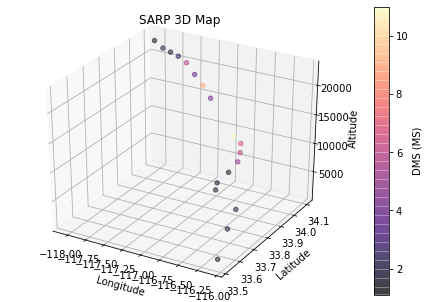

In [116]:
three_d_cmap(flight_1_2015, 'DMS (MS)', 'test.gif',)